# Project: Finding Donors for *CharityML*

Supervised learning in Python using scikit-learn, random forests, logistic regression, and SVM 

Author: Christoph Schauer <br>
Date: 16/11/2018

----
## Introduction

This jupyter notebook is an updated version of my course project for the module Supervised Learning of [Udacity's Data Scientist Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025). 

The goal of this project is to classify the annual income of the persons in this dataset as correctly as possible. From the project description:

In this project, the following tasks are performed:

* Exploratory analysis of the dataset
* Prepare the data for use in ML
* Train three classification models with default hyperparameters
* Use the best model and tune it with tunegrid
* Train this model again using only the most important features

Some more context from the project description:

*In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features.*

*The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here includes small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.*

The original project contains lots of fluff text, which I edited a bit for brevity. Two questions were also dropped because they were pretty weird. The code is cleaned up a bit as well.

----
## Exploring the Data
Load the necessary Python libraries and load the census data. The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

Plots are generated by using functions defined in the imported script visuals.py

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from time import time
from IPython.display import display
%matplotlib inline

# Import supplementary visualization code visuals.py
import visuals as vs

# Load the Census dataset
data = pd.read_csv("census.csv")

# Display the first records
display(data.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. Compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`

In [8]:
# Total number of records
n_records = len(data)

# Number of records where individual income is more than $50,000
n_greater_50k = len(data[data["income"] == ">50K"])

# Number of records where individual income is at most $50,000
n_at_most_50k = len(data[data["income"] == "<=50K"])

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/n_records*100

# Print results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


### Features in the dataset

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preprocessing
For this dataset, there are no invalid or missing entries we must deal with. However, certain features must be adjusted.

### Transforming Skewed Continuous Features

Two features have highly skewed feature distributions: `'capital-gain'` and `'capital-loss'`. For these features, I apply a logarithmic transformation on the data so that the relatively high number very large and very small values do not negatively affect the performance of a learning algorithm.

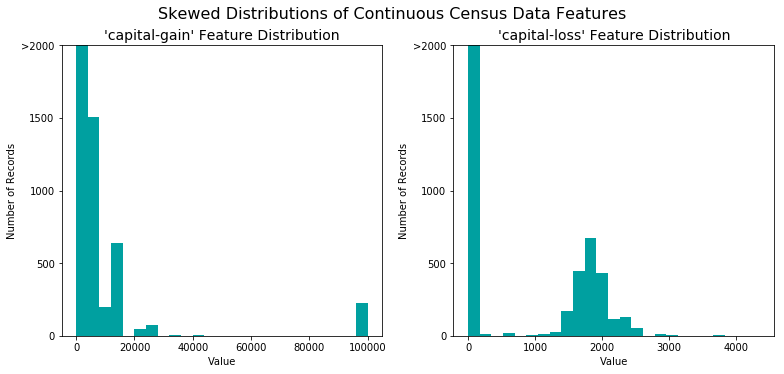

In [9]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

Perform a transformation on the data and visualize the results.

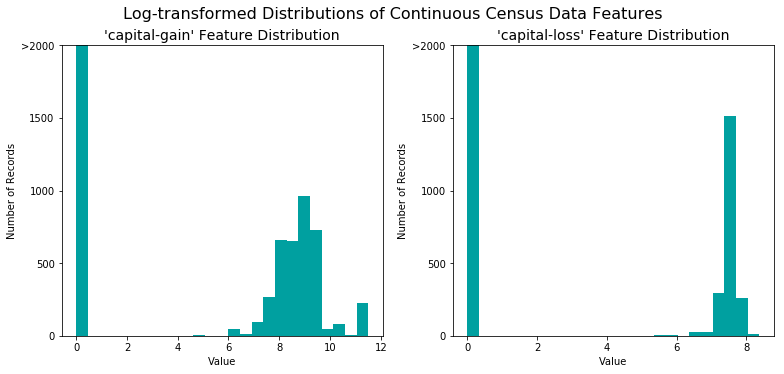

In [10]:
# Log-transform the skewed features
skewed = ["capital-gain", "capital-loss"]
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the distributions of the transformed features
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

Normalize all numerical features.

In [15]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### One-hot encoding

One-hot encode all categorical features and convert the target label `'income_raw'` to numerical entries. Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [16]:
# One-hot encode factors
categorical = ["workclass", "education_level", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
features_onehot = pd.get_dummies(features_log_minmax_transform[categorical])
features_final = pd.concat([features_log_minmax_transform[numerical], features_onehot], axis = 1)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({"<=50K": 0, ">50K": 1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data
Split the data into training and test sets. 80% of the data will be used for training and 20% for testing.

In [17]:
from sklearn.model_selection import train_test_split

# Split features and income data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2, random_state = 123)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance

In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a naive predictor.*

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately.

Looking at the distribution of the two classes, it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data. Therefore the **F-Score** will be used as evaluation metric instead of **accuracy**.

### Question 1 - Naive Predictor Performace
If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? Use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [19]:
# Calculate accuracy, precision and recall
TP = np.sum(income)
FP = income.count() - np.sum(income)
TN = 0
FN = 0
accuracy = TP/income.count()
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall
fscore = (1+0.5**2)*precision*recall/(0.5**2*precision+recall)

# Print results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Question 2 - Model Application
List three supervised learning models that are appropriate for this problem that you will test on the census data. For each model chosen

- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

Structure your answer in the same format as above, with 3 parts for each of the three models you pick.

**Logistic Regression** 

Strengths:
* Performs well when many categorical features are present
* Can be updated quite easily with new data using stochastic gradient descent
* Model output is somewhat interpretable, i.e. you can make statements about the effect of individual features on the likelihood of either outcome coming to pass

Weaknesses:
* Has difficulties capturing non-linear boundaries, and hence cannot capture complex relationships between features and outcome

Good candidate for the problem because:
* The dataset includes many categorical features
* The underlying data - with income as continous instead of a categorical variable - could lend itself well to a linear regression model, making a logit model a promising candidate
* Interpretability of the model may be useful for the charity (e.g. that married people having a higher income)

**Random Forest**

Strengths:
* Able to model non-linear decision boundaries. 
* Fits to a wide range of data, placing few restrictions on the nature of the data
* Scales well to larger datasets, a.o. because the trees can be estimated in parallel on many cores
* Relatively low computing times due to the simplicity of the underlying model, especially when using many cores
* Is an ensemble method with the corresponding benefits (low variance, insensitive to outliers, etc) 
* Robust to the inclusion of irrelevant features (unlike e.g. linear regression)
* Comes with good methods of handling missing values out of the box

Weaknesses:
* Longer training times than simpler algorithms like naive bayes or logit models, especially when many hundreds of trees are estimated

Good candidate for the problem because:
* Random forest are a good candidate in a wide range of settings, especially when you don't know too much about the underlying data, like here
* Quick
* In a real-world application, missing values might be common, which random forest can handle pretty well

**Support Vector Machines**

Strengths:
* Can capture complex boundaries with radial and rbf kernels
* Can be tuned to avoid overfitting
* If they do work, they can work quite well
* Good for smaller datasets

Weaknesses:
* More complicated than random forests or logistic regressions: Choosing wrong hyperparameters, especially wrong kernels, can do serious harm to prediction accuracy
* SVM don't scale well to large datasets, with computing times quickly increasing

Good candidate for the problem because:
* The dataset used here is not too large, keeping computation times within reason
* I just wanted to try out a more advanced method that is totally different from the others (i.e. not naive bayes, not boosting)

### Implementation - Creating a Training and Predicting Pipeline

Create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
 - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [23]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

# Define pipeline functions
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    
    results = {}
    
    # Fit the learner to the training data and calculate training time
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    results['train_time'] = end - start
        
    # Get the predictions for the test set and the first 300 training samples and calculate training time
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
    
    results['pred_time'] = end - start
            
    # Compute accuracy and F-scores
    results['acc_train'] = accuracy_score(predictions_train, y_train[:300]) 
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
        
    # Return results
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    return results

### Implementation: Initial Model Evaluation
In the code cell, implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
- Use a `'random_state'` for each model you use, if provided.
- **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
- Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


C:\Users\chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


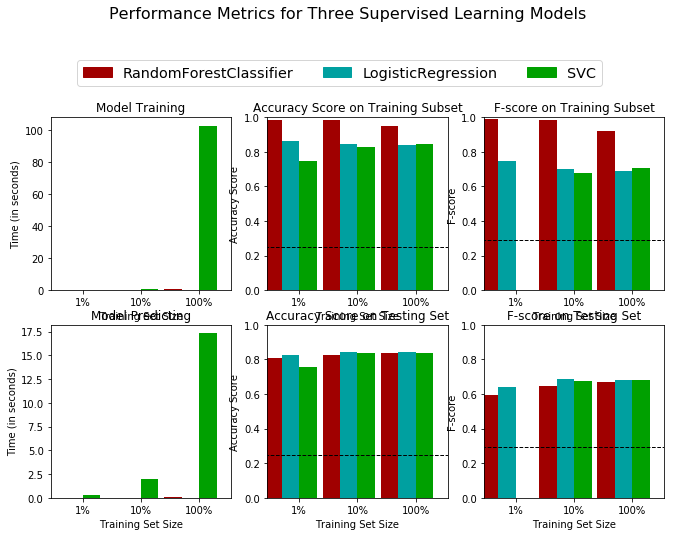

In [27]:
# Suppress FutureWarning; this notebook uses slightly outdated code
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

# Initialize the three models
clf_A = RandomForestClassifier(random_state = 0)
clf_B = LogisticRegression(random_state = 0)
clf_C = SVC(random_state = 0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(X_train)
samples_10 = int(len(X_train)/10)
samples_1 = int(len(X_train)/100)

# Collect results
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results

In this final section, choose from the three supervised learning models the best model to use on the student data. Perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

All 3 estimated models with their default settings have almost the same accuracy and F-score for the testing set when 100% of the training data is used. 

As training and prediction times for the Support Vector Machine model are much higher than for the other two, with a difference that would only increase for bigger datasets, this model is out. 

In the end, for this data set, it looks like a toss-up between the random forest model and the logistic regression model. The training time for the logit model is faster than the random forest model and it should be well-suited for this type of data - as would a linear regression model if income was recorded as continuous variable instead of a factor with only two values.

However, I decided to use the random forest model. This model is still quick enough to train, and training can be parallelized - although training time will increase if hundreds instead of the default 10 trees are estimated - and scales well to larger datasets. In addition, random forests are more flexible than the logistic regression model, as they allow for highly irregular decision boundaries. Random forest algorithms are also able to easily handle observations with missing values, which might be frequent in practice in this context.

### Implementation: Model Tuning
Fine tune the chosen model using the entire training set for this. In the code cell below, implement the following:
- Initialize the classifier you've chosen and store it in `clf`.
- Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
- Example: `parameters = {'parameter' : [list of values]}`.
- **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [28]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = RandomForestClassifier(n_estimators = 200, n_jobs = -1, random_state = 0)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {"max_features": [4, 8, 10, 12, 16], 
              "max_depth": [2, 4, 8, 12, 16, 24, 32, 64]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier and find the optimal parameters
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions with the unoptimized and optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chris\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Unoptimized model
------
Accuracy score on testing data: 0.8452
F-score on testing data: 0.6857

Optimized Model
------
Final accuracy score on the testing data: 0.8572
Final F-score on the testing data: 0.7287


In [32]:
print("The hyperparameters of the best model found by tunegrid are:")
print(best_clf)

The hyperparameters of the best model found by tunegrid are:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features=16, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.8452            | 0.8572          |
| F-score        | 0.6857            | 0.7287          |

Accuracy of the optimized model is virtually the same as for the unoptimized model. The F-Score is a bit higher, howerever. That said, I only optimized over two hyperparameters of the random forest algorithm, as using all would mean a higher-dimensional tunegrid and lead to long training times.

In any case, both scores are much higher than those of the naive predictor, which had an accuracy score of 0.2478 and an F-score: 0.2917.

----
## Feature Importance and feature selection

### Extract feature importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, and fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

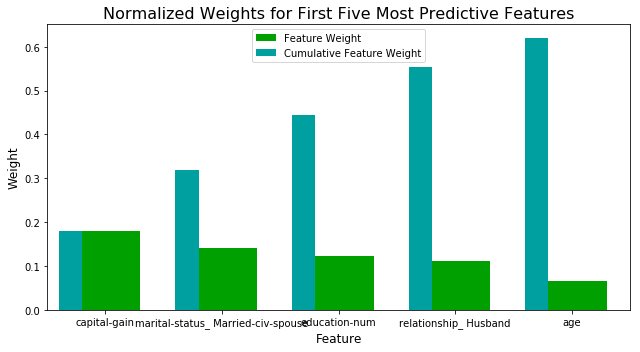

In [33]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = best_clf
model = model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Feature Selection
How does the model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute 60% of the importance of all features present in the data. Train the model on the same training set with only the top five important features. 

In [34]:
# Import functionality for cloning a model
from sklearn.base import clone

X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# clf = clone(best_clf): doesn't work because the best random forest model has more max features than 5 '''
clf = RandomForestClassifier(max_depth = 12, n_estimators = 200, n_jobs = -1, random_state = 0)
clf.fit(X_train_reduced, y_train)
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8572
F-score on testing data: 0.7287

Final Model trained on reduced data
------
Accuracy on testing data: 0.8492
F-score on testing data: 0.7045


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

Selecting only the top five features leads to a lower accuracy and F-score, but not by much. So, yes, if timing was a factor, I would recommend using the reduced set. Or rather, _a_ reduced set, which includes at least all the most relevant factor variables, and not only certain dummies generated from these factors.